In [1]:
import fcwt
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
from vit_pytorch.vit_3d import ViT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load dataset
x = pickle.load(open('data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')
data = x['data']
labels = x['labels']

relevant_channels = data[:, :32, :]
relevant_labels = labels[:, :2]

classes = []
for trial in range(40):
    # 4 valence-arousal classes
    valence, arousal = relevant_labels[trial][0], relevant_labels[trial][1]
    cls = 0 if valence < 4.5 and arousal < 4.5 else \
                    1 if valence < 4.5 else \
                    2 if arousal < 4.5 else 3
    classes.append(cls)

In [3]:
# initialize constant variables
# paramaters for calculating cwt, not to be changed
fs = 128 
f0 = 4 # lowest frequency
f1 = 45 # highest frequency
fn = 32 # number of frequencies, match channel number for square frame

In [23]:
total_cwt = np.zeros((1024, 8064))

for channel in range(32):    
    signal = relevant_channels[0][channel]
    freqs, current_cwt = fcwt.cwt(signal, fs, f0, f1, fn)
    start = channel * fn
    end = (channel + 1) * fn
    total_cwt[start:end, :] = abs(current_cwt) 

In [15]:
print(np.linspace(f0, f1, fn))

[ 4.          5.32258065  6.64516129  7.96774194  9.29032258 10.61290323
 11.93548387 13.25806452 14.58064516 15.90322581 17.22580645 18.5483871
 19.87096774 21.19354839 22.51612903 23.83870968 25.16129032 26.48387097
 27.80645161 29.12903226 30.4516129  31.77419355 33.09677419 34.41935484
 35.74193548 37.06451613 38.38709677 39.70967742 41.03225806 42.35483871
 43.67741935 45.        ]


In [24]:
# convert 2D time sample x channel-frequency format (x, y) to 3D channel x frequency x time format (x, y, z)
# each 'frame' in all_frames is a 2D image showing each channel's CWT value for that time sample
all_frames = []

for sample in range(8064):
    frame = np.zeros((32, 32))
    for channel in range(32):
        start = channel * fn
        end = (channel + 1) * fn
        frame[:, channel] = total_cwt[start:end, sample]

    # normalize frame
    norm_frame = (frame - frame.min()) / (frame.max() - frame.min())
    # scale to 0-255
    scaled_frame = (norm_frame * 255).astype(np.uint8)

    # stack for RGB
    frame_rgb = np.stack((scaled_frame,) * 3, axis=0)
    frame_rgb = np.clip(frame_rgb, 0, 255).astype(np.uint8)

    if sample == 0:
        print("Frame shape:", frame_rgb.shape)
    #all_frames.append(frame_rgb)
    all_frames.append(frame)

Frame shape: (3, 32, 32)


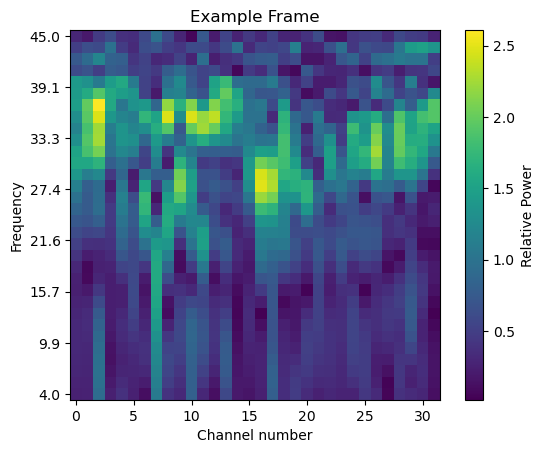

In [26]:
plt.imshow(all_frames[0], origin='lower')
plt.title("Example Frame")
plt.xlabel("Channel number")
plt.ylabel("Frequency")
tick_positions = np.linspace(0, 31, 8)
tick_labels = np.linspace(f0, f1, 8)
plt.yticks(tick_positions, ["{:.1f}".format(val) for val in tick_labels])
plt.colorbar().set_label("Relative Power")

In [35]:
# write .gif file
from array2gif import write_gif
gif_dataset = np.array(all_frames)
print("Dataset shape:", gif_dataset.shape)
write_gif(gif_dataset, 'test.gif', fps = 128)

Dataset shape: (8064, 3, 32, 32)


In [22]:
# split trial into 6-second samples as suggested in Arjun et al. 2021
six_sec_samples = []
sample_classes = []
window_size = 6 * 128

for i in range(0, 8064, window_size):
    if i + window_size > 8064:
        break
    sample = all_frames[i:i+window_size]
    six_sec_samples.append(sample)
    sample_classes.append(classes[0]) # TODO: replace with correct index in final loop

In [23]:
array = np.array(six_sec_samples)
array.shape
# TODO: when looking at all trials ensure that shape is (10*40 samples, 768 frames, 32 height, 32 width)

(10, 768, 3, 32, 32)

In [24]:
class CWTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(np.array(data), dtype=torch.float32).permute(0, 2, 1, 3, 4)
        self.data = self.data / 255.0
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [25]:
train_data, test_data, train_labels, test_labels = train_test_split(
    six_sec_samples, sample_classes, test_size=0.2, random_state=23, stratify=sample_classes
)
train_loader = DataLoader(CWTDataset(train_data, train_labels, device=device), batch_size=4)
test_loader = DataLoader(CWTDataset(test_data, test_labels, device=device), batch_size=4)

In [26]:
test_sample, test_label = next(iter(train_loader))
print(f"Input shape: {test_sample.shape}") 

Input shape: torch.Size([4, 3, 768, 32, 32])


In [27]:
vit = ViT(
    image_size=32,
    frames=768,
    image_patch_size=4,
    frame_patch_size=192,
    num_classes=4,
    dim=512,
    depth=6,
    heads=4,
    mlp_dim=1024,
    channels=3,
    dropout=0.2,
    emb_dropout=0.1,
    pool='cls'
).to(device)

In [47]:
np.shape(train_data)

(8, 768, 3, 32, 32)

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=3e-4, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

print("Training...")
for epoch in range(10):
    vit.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = vit(inputs)
        loss = loss_fn(outputs, targets)
        print(f"\tEpoch: {epoch}/50\tLoss:{loss:.3f}", end='\r')
        loss.backward()
        optimizer.step()
    scheduler.step()

vit.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = vit(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
accuracy = 100 * correct / total
print(f"\tTest accuracy: {accuracy:.2f}%")



Training...


	Test accuracy: 100.00%
